In [66]:
from googleapiclient.discovery import build
import pandas as pd
from dateutil import parser
from IPython.display import JSON

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

api_key = "HIDDEN"

channel_ids = ['UCX6OQ3DkcsbYNE6H8uQQuVA', ]

api_service_name = "youtube"
api_version = "v3"

    # Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [24]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )
    response = request.execute()

    #loop through items
    for item in response['items']:
        data = {'channelName':item['snippet']['title'],
                'subscribers':item['statistics']['subscriberCount'],
                'views':item['statistics']['viewCount'],
                'totalVideos':item['statistics']['videoCount'],
                'playlistId':item['contentDetails']['relatedPlaylists']['uploads']
        }

        all_data.append(data)
    return(pd.DataFrame(all_data))

In [25]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [26]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,MrBeast,95400000,15676418730,721,UUX6OQ3DkcsbYNE6H8uQQuVA


In [27]:
playlist_id = "UUX6OQ3DkcsbYNE6H8uQQuVA"

def get_video_ids(youtube, playlist_id):
    
    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id, 
        maxResults=50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
        
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part="contentDetails",
                    playlistId=playlist_id, 
                    maxResults=50, 
                    pageToken=next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [28]:
video_ids = get_video_ids(youtube, playlist_id)

In [29]:
len(video_ids)

721

In [59]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags'],
                             'statistics': ['viewCount', 'likeCount', 'commentCount'],
                             'contentDetails': ['duration', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [60]:
video_details_df = get_video_details(youtube, video_ids)
video_details_df

,video_id,channelTitle,title,description,tags,viewCount,likeCount,commentCount,duration,caption
0,hD1YtmKXNb4,MrBeast,"$10,000 Every Day You Survive Prison",SUBSCRIBE IN THE NEXT 7 DAYS FOR A CHANCE TO W...,None,54717915,2782132,136229,PT13M59S,false
1,LnlKwzc_TNA,MrBeast,"Would You Swim With Sharks For $100,000?",Try Experian Boost to boost your credit scores...,None,57195854,2389138,97004,PT9M,false
2,3jS_yEK8qVI,MrBeast,World’s Most Dangerous Escape Room!,Buy my new chocolate bar: https://www.Feastabl...,None,91002415,3377761,139677,PT8M2S,false
3,00NgUctWoLQ,MrBeast,"Extreme $1,000,000 Hide And Seek",I didn't expect that to happen at the end I wa...,None,64541694,3026304,136077,PT12M9S,true
4,x9TQ6culXIA,MrBeast,"$1,000,000 Influencer Tournament!",That was so close at the end I can't believe t...,None,52150104,2707044,91580,PT12M5S,true
...,...,...,...,...,...,...,...,...,...,...
716,7qj3nuF9Dzw,MrBeast,Most Epic minecraft skin EVER (Psy),Psy in minecraft!!! drop a like for psy's mo...,"[psy, minecraft, epic, skin, most, ever]",488532,21043,2411,PT30S,false
717,Y74b7WlcEpk,MrBeast,More birds IN MINECRAFT!!,Basically what this mod does is adds more bird...,"[birds, minecraft, in, more, must, see, epic]",586864,25047,2747,PT2M6S,false
718,Z8nEEdXTaX0,MrBeast,Boxy item mod Minecraft. EPIC,At the begining i said i was mrbeast6000.... i...,"[boxy, item, mod, minecraft, epic]",668811,29172,3353,PT1M30S,false
719,jP82d277Cc8,MrBeast,Harry Potter Mod In Minecraft! EPIC MUST SEE M...,One of the coolest mods i have ever seen\n\nMo...,"[Harry Potter minecraft, minecraft, minecraft ...",2382771,None,6019,PT3M59S,false


In [61]:
video_details_df.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
tags             True
viewCount       False
likeCount        True
commentCount     True
duration        False
caption         False
dtype: bool

In [62]:
video_details_df.dtypes

video_id        object
channelTitle    object
title           object
description     object
tags            object
viewCount       object
likeCount       object
commentCount    object
duration        object
caption         object
dtype: object

In [64]:
numeric_columns = ['viewCount', 'likeCount', 'commentCount']
video_details_df[numeric_columns] = video_details_df[numeric_columns].apply(pd.to_numeric, errors='coerce',axis=1)

In [69]:
import isodate
video_details_df['durationSecs'] = video_details_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_details_df['durationSecs'] = video_details_df['durationSecs'].astype('timedelta64[s]')

In [88]:
video_details_df['tagCount'] = video_details_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [77]:
##Best performing videos

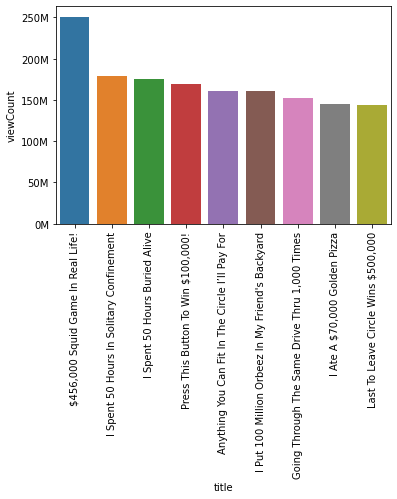

In [78]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_details_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000000) + 'M'))

In [79]:
##Worst performing videos

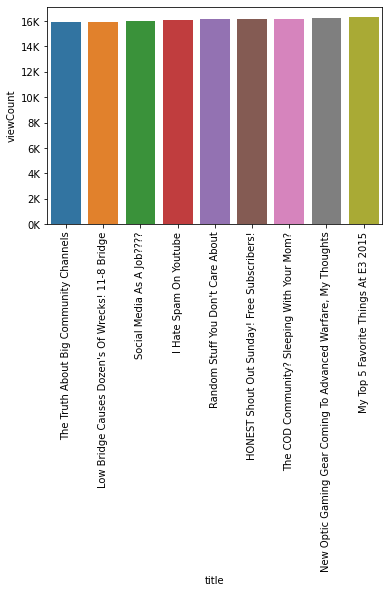

In [81]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_details_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

In [100]:
##Video Duration vs Likes / Tag counts vs Views

<AxesSubplot:xlabel='tagCount', ylabel='viewCount'>

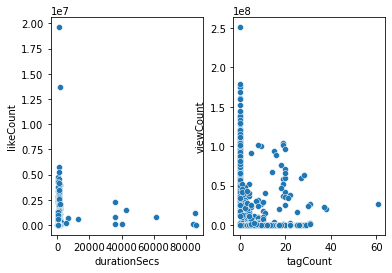

In [98]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_details_df, x = 'durationSecs', y = 'likeCount', ax = ax[0])
sns.scatterplot(data = video_details_df, x = 'tagCount', y = 'viewCount', ax = ax[1])

In [101]:
##Video duration dist

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

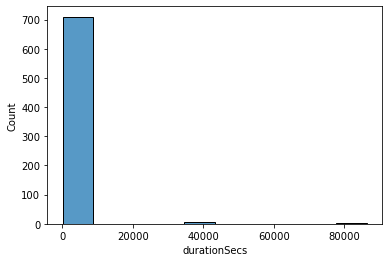

In [110]:
sns.histplot(data = video_details_df, x = 'durationSecs', bins=10)